In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random 

In [5]:
train = pd.read_csv("data/train.csv").to_numpy()
test = pd.read_csv("data/test.csv").to_numpy()

train[:,0]

x_train, y_train = train[:,1:], train[:,0]
x_test, y_test = test[:,1:], test[:,0]
x_train, x_test = x_train/255, x_test/255 # convert all pixels to be between 0 and 1


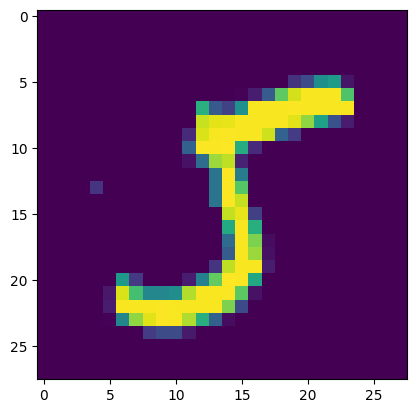

label: 5


In [6]:
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest')
    return plt

n = random.randint(0, x_train.shape[0]-1)
gen_image(x_train[n]).show()
print(f"label: {y_train[n]}")

In [32]:
def one_hot(x, n=10):
    return np.eye(n)[x]  

def cross_entropy_loss(ygt, ypred):
    return -np.sum(ygt*np.log(ypred))

In [1]:
a = np.random.rand(10,4)
m,n = a.shape[0], a.shape[1]
ones = np.ones((m,n))
0* ones

NameError: name 'np' is not defined

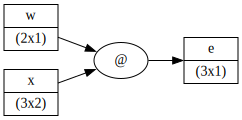

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nanograd.autograd import Tensor
from nanograd.visualize import draw_dot
np.random.seed(69)

# a = Tensor(np.random.randint(5,size=(2,4))); a.label='a'
# b = Tensor(np.random.randint(5,size=(4,2))); b.label='b'
# c = a * b; c.label='c'

x = Tensor(np.random.randint(5,size=(3,2))); x.label='x'
w = Tensor(np.random.randint(5, size=(2,1))); w.label='w'
e = x.matmul(w); e.label='e'

draw_dot(e)


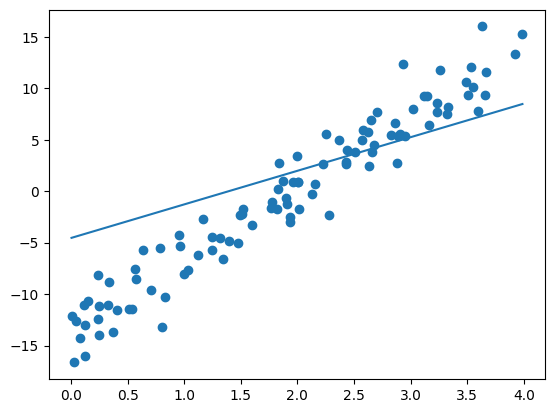

In [2]:
x = np.random.random_sample((100)).reshape(-1,1)*4
w = np.array(np.random.normal(0,4)).reshape(1,1)
b = np.array(np.random.normal(0,4)).reshape(1,1)
n = np.random.normal(0,2, size=100).reshape(-1,1)
y = 6.9*(x-2) + n


plt.scatter(x,y)
x_line = [np.min(x), np.max(x)]
y_line = [w[0]*x + b[0] for x in x_line]
plt.plot(x_line, y_line)
plt.show()

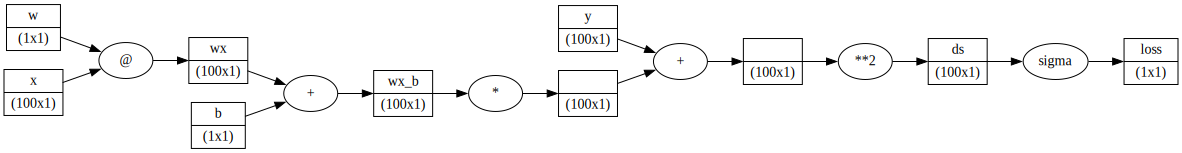

In [3]:
x_tensor = Tensor(x); x_tensor.label='x'
w_tensor = Tensor(w); w_tensor.label = 'w'
b_tensor = Tensor(b); b_tensor.label = 'b'
y_tensor = Tensor(y); y_tensor.label = 'y'
wx = x_tensor.matmul(w_tensor); wx.label = 'wx'
wx_b = wx + b_tensor; wx_b.label='wx_b'
delta_sq = ((y_tensor - wx_b)**2); delta_sq.label = 'ds'
loss = delta_sq.sum(); loss.label = 'loss'
draw_dot(loss)


In [4]:
loss.grad = 1
# loss.backward()


In [6]:
# topological order all of the children in the graph
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(loss)
print(topo)

# go one variable at a time and apply the chain rule to get its gradient
loss.grad = 1 * np.ones((loss._n,loss._m))
for v in reversed(topo):
    v._backward()

[<nanograd.autograd.Tensor object at 0x113775780>, <nanograd.autograd.Tensor object at 0x1037d0bb0>, <nanograd.autograd.Tensor object at 0x1037d0a90>, <nanograd.autograd.Tensor object at 0x1037d0af0>, <nanograd.autograd.Tensor object at 0x1037d1d50>, <nanograd.autograd.Tensor object at 0x1037d0820>, <nanograd.autograd.Tensor object at 0x1037d1c60>, <nanograd.autograd.Tensor object at 0x1037d3d60>, <nanograd.autograd.Tensor object at 0x1037d1a80>, <nanograd.autograd.Tensor object at 0x1037d1b10>]


ValueError: non-broadcastable output operand with shape (1,1) doesn't match the broadcast shape (100,1)

In [29]:
delta_sq.grad

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

## Nanograd

In [24]:
from nanograd.nn import MLP

In [25]:
inputs = x_train.shape[1]
model = MLP(inputs, [10,10,10])
y_pred = [model(x) for x in x_train[0:100]]

In [33]:
print(y_pred[0])
print(one_hot(y_train[0]))
print(cross_entropy_loss(y_train[0], y_pred[0]))

[Value(data=0.9035859934331931, grad=0), Value(data=0.9627840072180951, grad=0), Value(data=-0.0643963727334691, grad=0), Value(data=-1.4492560049881216, grad=0), Value(data=1.2870165827077213, grad=0), Value(data=-0.30408739209404034, grad=0), Value(data=-0.5189935694516793, grad=0), Value(data=-1.1177797944366286, grad=0), Value(data=0.05444642789262977, grad=0), Value(data=-2.84553116440932, grad=0)]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


TypeError: loop of ufunc does not support argument 0 of type Value which has no callable log method

In [8]:
for k in range(500):
    # forward pass
    y_pred = [model(x) for x in x_train]
    loss = sum((y_out - y_gt)**2 for y_gt, y_out in zip(y_train, y_pred))

    # backward pass
    model.zero_grad()
    loss.backward()
    
    # update
    for p in model.parameters():
        p.data += -0.03 * p.grad
    
    if k % 10 == 0:
        print(k, loss.data)


0 0.05415775960707065
10 0.040699425118808266
20 0.03079455062115722
30 0.02339341725494989
40 0.017807215246613568
50 0.013567695111271956
60 0.010341340389221748
70 0.007882819604551948
80 0.0060083503169639065
90 0.004578937830048139
100 0.0034889465562247817
110 0.0026578954357970213
120 0.002024393867247308
130 0.0015415885851527208
140 0.0011737158405277278
150 0.0008934784517670474
160 0.0006800453639830495
170 0.000517523980735707
180 0.0003937928379594476
190 0.00029960947026029847
200 0.00022792865225613313
210 0.000173381529849735
220 0.00013187780094975392
230 0.00010030198729932369
240 7.628163100279359e-05
250 5.8010449815962136e-05
260 4.411346944718423e-05
270 3.3544203728698736e-05
280 2.5506291865383657e-05
290 1.939379246170411e-05
300 1.474570433945301e-05
310 1.121133231998693e-05
320 8.523917444945556e-06
330 6.480563352215475e-06
340 4.92695807312112e-06
350 3.745747394289943e-06
360 2.8476882068589516e-06
370 2.164917916469832e-06
380 1.6458342907801964e-06
390 

In [9]:
y_pred

[Value(data=1.0000110877427093, grad=2.2175485418607366e-05),
 Value(data=-0.9997875517849408, grad=0.0004248964301183378),
 Value(data=-0.9998671636816072, grad=0.0002656726367855633),
 Value(data=1.0000110877427093, grad=2.2175485418607366e-05)]

In [52]:
import math
import random
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            #https://en.wikipedia.org/wiki/Hyperbolic_functions#Derivatives
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [53]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any values in the graph, create a rectangular record node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it 
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [54]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [160]:
n = MLP(3, [10,4,1])

for k in range(300):
    # forward pass
    y_pred = [n(x) for x in xs]
    loss = sum((y_out - y_gt)**2 for y_gt, y_out in zip(ys, y_pred))

    # backward pass
    n.zero_grad()
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.03 * p.grad
    
    if k % 10 == 0:
        print(k, loss.data)


0 15.644302330276453
10 0.12789674936858736
20 0.02669108364639066
30 0.002716197150222608
40 0.00026326915684857726
50 2.38239795562712e-05
60 2.0954969835986387e-06
70 1.827411707068524e-07
80 1.5895734839687593e-08
90 1.3816510721278513e-09
100 1.200659505247582e-10
110 1.0433090182590326e-11
120 9.065623759111399e-13
130 7.87734658627935e-14
140 6.844811463879642e-15
150 5.947614628229596e-16
160 5.168018518533631e-17
170 4.490610343309173e-18
180 3.9019945862954174e-19
190 3.3905337950954747e-20
200 2.9460908076470287e-21
210 2.559953789497077e-22
220 2.2245557212727158e-23
230 1.932671019667334e-24
240 1.6792024796633683e-25
250 1.4636118479066398e-26
260 1.2758469287269017e-27
270 1.1312758418935072e-28
280 9.577264427448846e-30
290 1.836566794967668e-30


In [161]:
y_pred

[Value(data=1.0000000000000007, grad=1.3322676295501878e-15),
 Value(data=-0.9999999999999999, grad=2.220446049250313e-16),
 Value(data=-0.9999999999999996, grad=8.881784197001252e-16),
 Value(data=0.9999999999999996, grad=-8.881784197001252e-16)]

In [152]:


# # forward pass
y_pred = [n(x) for x in xs]
loss = sum((y_out - y_gt)**2 for y_gt, y_out in zip(ys, y_pred))

# backward pass
n.zero_grad()
loss.backward()

# update
for p in n.parameters():
    p.data += -0.05 * p.grad

loss, y_pred

(Value(data=2.9400018210573545e-05, grad=1),
 [Value(data=0.9965012300542382, grad=-0.00699753989152363),
  Value(data=-0.9979128801676643, grad=0.004174239664671342),
  Value(data=-0.9992508893611005, grad=0.0014982212777989723),
  Value(data=0.9965012300542382, grad=-0.00699753989152363)])

[Value(data=3.063175324560093, grad=0),
 Value(data=-5.174558671545837, grad=0),
 Value(data=0.8995198412257644, grad=0),
 Value(data=0.7388069500948937, grad=0)]

In [839]:
n.layers[0].parameters()

[Value(data=0.9952375350608573, label=),
 Value(data=0.3481276520024903, label=),
 Value(data=-0.34357154982839777, label=),
 Value(data=0.25998945495712955, label=),
 Value(data=0.18451892991351748, label=),
 Value(data=-0.23510638454343002, label=),
 Value(data=-0.4906381666045556, label=),
 Value(data=-0.7181546648417907, label=)]